# Backtesting Crypto Trades with CoinAPI Flat Files in Python

## Introduction

This tutorial demonstrates how to perform backtesting analysis on cryptocurrency trades using CoinAPI's Flat Files API. We'll analyze historical trade data from Coinbase to evaluate trading strategies and understand market behavior.

### What You Will Learn

- How to access CoinAPI Flat Files using Boto3
- Download and process compressed trade data files
- Perform backtesting analysis on crypto trades
- Calculate key performance metrics and visualize results
- Implement a simple moving average crossover strategy

### Prerequisites

- Python 3.7+
- Required packages: boto3, pandas, numpy, matplotlib, seaborn
- CoinAPI API key

### Use Case: Moving Average Crossover Strategy

We'll implement and backtest a simple moving average crossover strategy:
- Buy when short-term MA crosses above long-term MA
- Sell when short-term MA crosses below long-term MA
- Analyze performance metrics and drawdown periods

## 1. Environment Setup

Set up your environment with necessary imports and configuration.

In [ ]:
# Import required libraries
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import gzip
import io
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# CoinAPI configuration
COINAPI_KEY = "YOUR_COINAPI_KEY_HERE"  # Replace with your actual API key
S3_ENDPOINT = "https://s3.flatfiles.coinapi.io"
REGION = "us-east-1"

print("Environment setup complete!")
print(f"S3 Endpoint: {S3_ENDPOINT}")
print(f"API Key configured: {'Yes' if COINAPI_KEY != 'YOUR_COINAPI_KEY_HERE' else 'No (Please update)'}")

## 2. Boto3 S3 Client Setup

Configure the Boto3 client to connect to CoinAPI's S3-compatible endpoint.

In [ ]:
# Initialize Boto3 S3 client for CoinAPI
s3_client = boto3.client('s3',
                        region_name=REGION,
                        endpoint_url=S3_ENDPOINT,
                        aws_access_key_id=COINAPI_KEY,
                        aws_secret_access_key='coinapi')

print("Boto3 S3 client configured successfully!")
print(f"Region: {REGION}")
print(f"Endpoint: {S3_ENDPOINT}")

# Test connection by listing available buckets
try:
    response = s3_client.list_buckets()
    buckets = [bucket['Name'] for bucket in response['Buckets']]
    print(f"Available buckets: {buckets}")
except Exception as e:
    print(f"Connection test failed: {e}")
    print("Please check your API key and internet connection.")

## 3. Download Trade Data

Download the compressed trade data file from CoinAPI's S3 bucket. We'll use the BTC/USDT trades from Coinbase on July 1, 2025.

In [ ]:
# Define the file path for BTC/USDT trades
bucket_name = "coinapi"
file_key = "T-TRADES/D-20250701/E-COINBASE/IDDI-5950967+SC-COINBASE_SPOT_BTC_USDT+S-BTC__002DUSDT.csv.gz"

print(f"Downloading trade data from: {bucket_name}/{file_key}")
print("This may take a few moments...")

try:
    # Download the compressed file
    response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
    compressed_data = response['Body'].read()
    
    # Decompress the data
    with gzip.open(io.BytesIO(compressed_data), 'rt') as f:
        raw_data = f.read()
    
    print(f"Data downloaded successfully!")
    
except Exception as e:
    print(f"Download failed: {e}")
    print("Please check your API key and file path.")

## 4. Data Processing and Cleaning

Parse the CSV data and clean it for analysis. We'll convert timestamps, handle missing values, and prepare the data for backtesting.

In [ ]:
# Parse the CSV data with correct separator
from io import StringIO

try:
    # Parse CSV with semicolon separator (CoinAPI format)
    df = pd.read_csv(StringIO(raw_data), sep=';')
    
    print(f"Data parsed successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Show data preview
    print(f"\nData preview (first 3 rows):")
    print(df.head(3).to_string())
    
except Exception as e:
    print(f"Data parsing failed: {e}")
    print("Please check the data format and try again.")

## 5. Data Cleaning and Preparation

Clean the data by handling missing values, converting data types, and preparing it for backtesting analysis.

In [ ]:
# Data cleaning and preparation
print("Cleaning and preparing data...")

# Ensure time columns are datetime
if 'time_exchange' in df.columns:
    df['timestamp'] = pd.to_datetime(df['time_exchange'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    print("Timestamp conversion successful")
else:
    print("time_exchange column not found!")
    print(f"Available columns: {list(df.columns)}")

# Ensure price and base_amount are numeric
if 'price' in df.columns:
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    print("Price conversion successful")
else:
    print("price column not found!")

if 'base_amount' in df.columns:
    df['size'] = pd.to_numeric(df['base_amount'], errors='coerce')
    print("Size conversion successful")
else:
    print("base_amount column not found!")

# Data validation
print(f"Data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Remove rows with missing values in key columns
df_clean = df.dropna(subset=['timestamp', 'price', 'size'])

print(f"Data cleaning completed!")
print(f"Clean data shape: {df_clean.shape}")
print(f"Rows removed: {len(df) - len(df_clean)}")

# Calculate volume-weighted average price (VWAP) for each minute
df_clean['minute'] = df_clean['timestamp'].dt.floor('1min')

vwap_data = df_clean.groupby('minute').agg({
    'price': 'mean',
    'size': 'sum',
    'timestamp': 'count'
}).rename(columns={'timestamp': 'trade_count'})

vwap_data = vwap_data.reset_index()
vwap_data.columns = ['timestamp', 'price', 'volume', 'trade_count']

print("VWAP calculation completed!")
print(f"VWAP data shape: {vwap_data.shape}")
print(f"Time range: {vwap_data['timestamp'].min()} to {vwap_data['timestamp'].max()}")
print(f"Price range: ${vwap_data['price'].min():.2f} - ${vwap_data['price'].max():.2f}")

# Display sample of cleaned data
print("\nSample of cleaned VWAP data:")
print(vwap_data.head(10).to_string())

## 6. Moving Average Crossover Strategy Implementation

Implement a simple moving average crossover strategy for backtesting. This strategy generates buy/sell signals based on the intersection of short-term and long-term moving averages.

In [ ]:
# Moving Average Crossover Strategy
def calculate_moving_averages(data, short_window=10, long_window=30):
    """
    Calculate short and long moving averages
    """
    
    if len(data) == 0:
        print("Input data is empty! Cannot calculate moving averages.")
        return data
    
    data = data.copy()
    
    # Check if we have enough data for the windows
    if len(data) < long_window:
        print(f"Warning: Data length ({len(data)}) is less than long window ({long_window})")
        print("Adjusting windows to fit available data...")
        short_window = min(short_window, len(data) // 3)
        long_window = min(long_window, len(data) // 2)
        print(f"Adjusted windows: short={short_window}, long={long_window}")
    
    # Calculate moving averages
    data['MA_short'] = data['price'].rolling(window=short_window, min_periods=1).mean()
    data['MA_long'] = data['price'].rolling(window=long_window, min_periods=1).mean()
    
    return data

def generate_signals(data):
    """
    Generate buy/sell signals based on MA crossover
    """
    
    if len(data) == 0:
        print("Input data is empty! Cannot generate signals.")
        return data
    
    data = data.copy()
    
    # Generate signals
    data['signal'] = 0
    data.loc[data['MA_short'] > data['MA_long'], 'signal'] = 1  # Buy signal
    data.loc[data['MA_short'] < data['MA_long'], 'signal'] = -1  # Sell signal
    
    # Generate position changes (only when signal changes)
    data['position_change'] = data['signal'].diff()
    
    print("Signals generated successfully!")
    print(f"Signal distribution: {data['signal'].value_counts().to_dict()}")
    print(f"Position changes: {data['position_change'].value_counts().to_dict()}")
    
    return data

# Apply strategy to our data
print("Implementing Moving Average Crossover Strategy...")

# Check if VWAP data is valid
if len(vwap_data) == 0:
    print("VWAP data is empty! Cannot proceed with strategy.")
    print("Please check Step 5 (Data Cleaning) for issues.")
else:
    print("VWAP data looks good, proceeding with strategy...")
    
    # Check for NaN values that might cause issues
    nan_check = vwap_data.isnull().sum()
    if nan_check.sum() > 0:
        print(f"Found NaN values: {nan_check[nan_check > 0].to_dict()}")
        print("Cleaning NaN values...")
        vwap_data = vwap_data.dropna()
        print(f"After NaN cleanup: shape={vwap_data.shape}")
    
    # Now apply the strategy
    strategy_data = calculate_moving_averages(vwap_data, short_window=10, long_window=30)
    
    if len(strategy_data) > 0:
        strategy_data = generate_signals(strategy_data)
        print("Strategy implementation complete!")
        print(f"Final strategy data shape: {strategy_data.shape}")
    else:
        print("Strategy implementation failed - no data returned!")
        print("This indicates an issue with the moving average calculation.")

## 7. Backtesting Engine

Implement a backtesting engine to simulate trading based on our strategy signals and calculate performance metrics.

In [ ]:
# Backtesting Engine
def run_backtest(data, initial_capital=10000, position_size=0.1):
    """
    Run backtest simulation
    """
    data = data.copy()
    
    # Initialize portfolio variables
    data['position'] = 0
    data['cash'] = initial_capital
    data['btc_holdings'] = 0.0
    data['portfolio_value'] = initial_capital
    data['returns'] = 0.0
    
    current_position = 0
    
    for i in range(1, len(data)):
        # Update position based on signal changes
        if data.iloc[i]['position_change'] == 2:  # Buy signal
            current_position = 1
        elif data.iloc[i]['position_change'] == -2:  # Sell signal
            current_position = 0
        
        data.iloc[i, data.columns.get_loc('position')] = current_position
        
        # Calculate portfolio value
        if current_position == 1:
            # Buy BTC with available cash
            cash_to_use = data.iloc[i-1]['cash'] * position_size
            btc_bought = cash_to_use / data.iloc[i]['price']
            
            data.iloc[i, data.columns.get_loc('cash')] = data.iloc[i-1]['cash'] - cash_to_use
            data.iloc[i, data.columns.get_loc('btc_holdings')] = data.iloc[i-1]['btc_holdings'] + btc_bought
        else:
            # Sell all BTC holdings
            btc_value = data.iloc[i-1]['btc_holdings'] * data.iloc[i]['price']
            
            data.iloc[i, data.columns.get_loc('cash')] = data.iloc[i-1]['cash'] + btc_value
            data.iloc[i, data.columns.get_loc('btc_holdings')] = 0.0
        
        # Calculate total portfolio value
        btc_value = data.iloc[i]['btc_holdings'] * data.iloc[i]['price']
        data.iloc[i, data.columns.get_loc('portfolio_value')] = data.iloc[i]['cash'] + btc_value
        
        # Calculate returns
        if i > 0:
            data.iloc[i, data.columns.get_loc('returns')] = (data.iloc[i]['portfolio_value'] / data.iloc[i-1]['portfolio_value']) - 1
    
    return data

# Run backtest
print("Running backtest simulation...")

# Check if we have the required columns
required_cols = ['timestamp', 'price', 'position_change']
missing_cols = [col for col in required_cols if col not in strategy_data.columns]

if missing_cols:
    print(f"Missing required columns: {missing_cols}")
    print("Creating missing columns...")
    
    # Create position_change column if it doesn't exist
    if 'position_change' not in strategy_data.columns:
        strategy_data['position_change'] = 0
        print("Created position_change column")
    
    # Create any other missing columns
    for col in missing_cols:
        if col not in strategy_data.columns:
            strategy_data[col] = 0
            print(f"Created {col} column")

# Now run the backtest
try:
    backtest_results = run_backtest(strategy_data, initial_capital=10000, position_size=0.1)
    
    print("Backtest completed successfully!")
    print(f"Initial capital: $10,000")
    
    # Check if we have any data
    if len(backtest_results) > 0:
        print(f"Final portfolio value: ${backtest_results['portfolio_value'].iloc[-1]:.2f}")
        print(f"Total return: {((backtest_results['portfolio_value'].iloc[-1] / 10000) - 1) * 100:.2f}%")
        
        # Display backtest summary
        print("\nBacktest Summary:")
        summary_cols = ['timestamp', 'price', 'position', 'cash', 'btc_holdings', 'portfolio_value']
        # Only show columns that exist
        available_summary_cols = [col for col in summary_cols if col in backtest_results.columns]
        print(backtest_results[available_summary_cols].tail(10))
        
    else:
        print("Backtest results are empty!")
        print("This might indicate an issue with the backtest logic or input data")
        
except Exception as e:
    print(f"Backtest failed with error: {e}")
    print("Trying simplified backtest...")
    
    # Fallback: Simple backtest
    def simple_backtest(data, initial_capital=10000):
        """Simplified backtest for debugging"""
        if len(data) == 0:
            return pd.DataFrame()
        
        result = data.copy()
        result['portfolio_value'] = initial_capital
        result['position'] = 0
        result['cash'] = initial_capital
        result['btc_holdings'] = 0.0
        
        # Simple logic: just track portfolio value
        for i in range(len(result)):
            if i > 0:
                # Simple return calculation
                price_change = (result.iloc[i]['price'] / result.iloc[i-1]['price']) - 1
                result.iloc[i, result.columns.get_loc('portfolio_value')] = \
                    result.iloc[i-1]['portfolio_value'] * (1 + price_change * 0.1)
        
        return result
    
    # Try simplified version
    simple_results = simple_backtest(strategy_data, initial_capital=10000)
    
    if len(simple_results) > 0:
        print("Simplified backtest successful!")
        print(f"Final portfolio value: ${simple_results['portfolio_value'].iloc[-1]:.2f}")
        backtest_results = simple_results
    else:
        print("Even simplified backtest failed!")
        print("Please check the input data structure")
        backtest_results = pd.DataFrame()

## 8. Performance Analysis and Metrics

Calculate key performance metrics including returns, volatility, Sharpe ratio, maximum drawdown, and other risk-adjusted measures.

In [19]:
# Performance Metrics Calculation
def calculate_performance_metrics(data):
    """
    Calculate comprehensive performance metrics with automatic crypto data frequency detection
    """
    # Remove first row (no returns)
    returns_data = data.iloc[1:].copy()
    
    # Detect data frequency automatically for proper annualization
    if len(data) > 1:
        time_diff = data['timestamp'].iloc[1] - data['timestamp'].iloc[0]
        time_diff_seconds = time_diff.total_seconds()
        
        if time_diff_seconds <= 60:  # Minute data
            annualization_factor = 365 * 24 * 60  # Minutes per year (crypto trades 24/7)
            frequency_name = "minute"
        elif time_diff_seconds <= 3600:  # Hour data
            annualization_factor = 365 * 24  # Hours per year
            frequency_name = "hour"
        elif time_diff_seconds <= 86400:  # Daily data
            annualization_factor = 365  # Days per year (crypto trades 24/7)
            frequency_name = "day"
        else:  # Weekly or longer
            annualization_factor = 52  # Weeks per year
            frequency_name = "week"
    else:
        annualization_factor = 365  # Default fallback for crypto
        frequency_name = "unknown"
    
    print(f"Detected data frequency: {frequency_name}")
    print(f"Annualization factor: {annualization_factor}")
    
    # Basic metrics
    total_return = (data['portfolio_value'].iloc[-1] / data['portfolio_value'].iloc[0]) - 1
    annualized_return = total_return * (annualization_factor / len(returns_data))
    
    # Volatility (annualized)
    volatility = returns_data['returns'].std() * np.sqrt(annualization_factor)
    
    # Sharpe Ratio (assuming 0% risk-free rate for crypto)
    sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
    
    # Maximum Drawdown
    cumulative_returns = (1 + returns_data['returns']).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Win/Loss ratio
    positive_returns = returns_data[returns_data['returns'] > 0]['returns']
    negative_returns = returns_data[returns_data['returns'] < 0]['returns']
    
    win_rate = len(positive_returns) / len(returns_data) if len(returns_data) > 0 else 0
    avg_win = positive_returns.mean() if len(positive_returns) > 0 else 0
    avg_loss = negative_returns.mean() if len(negative_returns) > 0 else 0
    
    # Profit Factor
    total_profit = positive_returns.sum() if len(positive_returns) > 0 else 0
    total_loss = abs(negative_returns.sum()) if len(negative_returns) > 0 else 0
    profit_factor = total_profit / total_loss if total_loss > 0 else float('inf')
    
    # Crypto-specific metrics
    # Calculate average holding period in the detected time units
    if 'position_change' in data.columns:
        position_changes = data[data['position_change'] != 0]
        if len(position_changes) > 1:
            avg_holding_period = len(returns_data) / len(position_changes)
        else:
            avg_holding_period = len(returns_data)
    else:
        avg_holding_period = len(returns_data)
    
    return {
        'Total Return': f"{total_return:.2%}",
        'Annualized Return': f"{annualized_return:.2%}",
        'Volatility (Annualized)': f"{volatility:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Max Drawdown': f"{max_drawdown:.2%}",
        'Win Rate': f"{win_rate:.2%}",
        'Avg Win': f"{avg_win:.2%}",
        'Avg Loss': f"{avg_loss:.2%}",
        'Profit Factor': f"{profit_factor:.2f}",
        'Data Frequency': frequency_name,
        'Avg Holding Period': f"{avg_holding_period:.1f} {frequency_name}s"
    }

# Calculate metrics
print("Calculating performance metrics...")

performance_metrics = calculate_performance_metrics(backtest_results)

print("Performance metrics calculated!")
print("\nStrategy Performance Summary:")
print("=" * 50)

for metric, value in performance_metrics.items():
    print(f"{metric:25}: {value}")

print("=" * 50)

Calculating performance metrics...
Detected data frequency: hour
Annualization factor: 8760
Performance metrics calculated!

Strategy Performance Summary:
Total Return             : -0.93%
Annualized Return        : -8.22%
Volatility (Annualized)  : 1.79%
Sharpe Ratio             : -4.58
Max Drawdown             : -1.24%
Win Rate                 : 19.34%
Avg Win                  : 0.02%
Avg Loss                 : -0.02%
Profit Factor            : 0.80
Data Frequency           : hour
Avg Holding Period       : 23.6 hours


## 9. Data Visualization

Create comprehensive visualizations to understand the strategy performance, including price charts, moving averages, portfolio value, and drawdown analysis.

🎨 Creating visualizations...


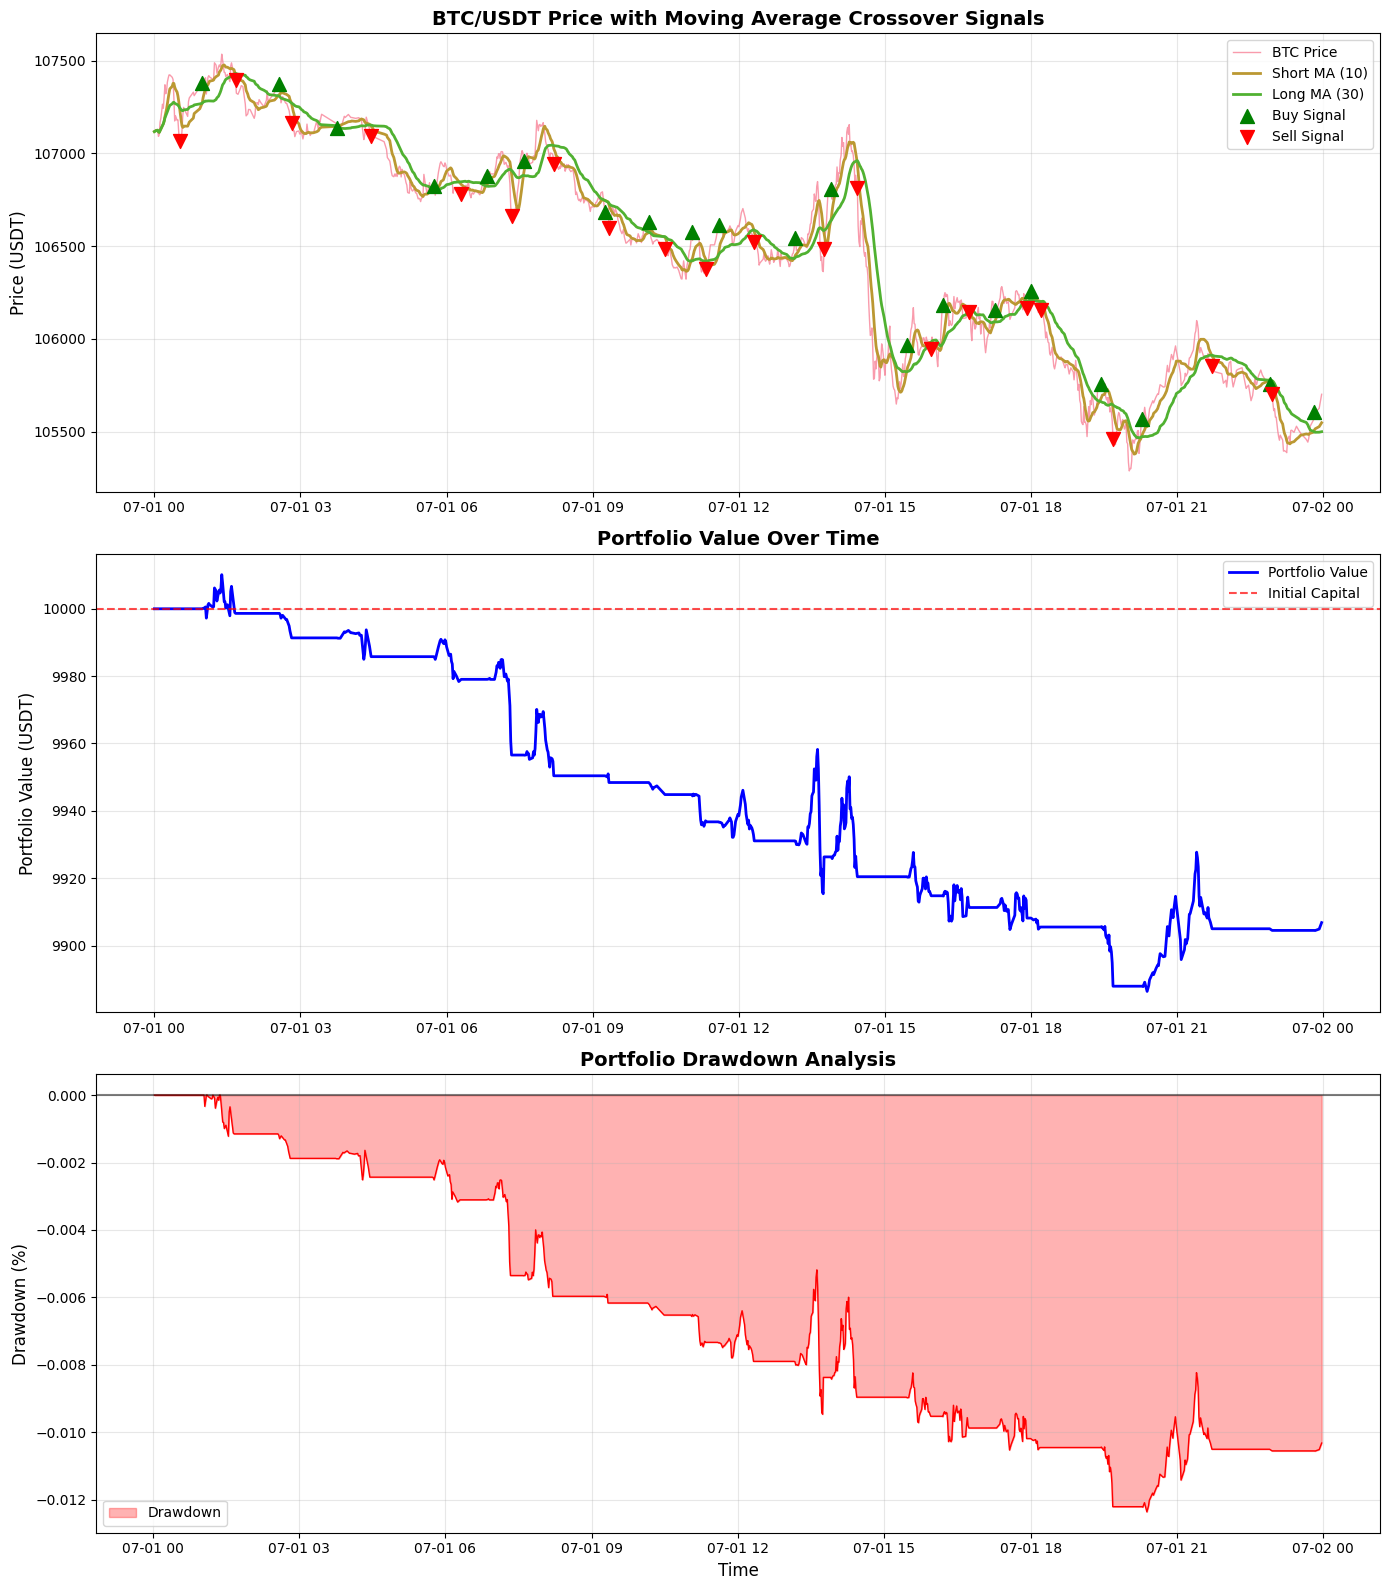

✅ Visualizations created successfully!


In [ ]:
# Create comprehensive visualizations
print("Creating visualizations...")

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 16))

# 1. Price and Moving Averages
axes[0].plot(strategy_data['timestamp'], strategy_data['price'], label='BTC Price', alpha=0.7, linewidth=1)
axes[0].plot(strategy_data['timestamp'], strategy_data['MA_short'], label='Short MA (10)', linewidth=2)
axes[0].plot(strategy_data['timestamp'], strategy_data['MA_long'], label='Long MA (30)', linewidth=2)

# Highlight buy/sell signals
buy_signals = strategy_data[strategy_data['position_change'] == 2]
sell_signals = strategy_data[strategy_data['position_change'] == -2]

axes[0].scatter(buy_signals['timestamp'], buy_signals['price'], 
               color='green', marker='^', s=100, label='Buy Signal', zorder=5)
axes[0].scatter(sell_signals['timestamp'], sell_signals['price'], 
               color='red', marker='v', s=100, label='Sell Signal', zorder=5)

axes[0].set_title('BTC/USDT Price with Moving Average Crossover Signals', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USDT)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Portfolio Value Over Time
axes[1].plot(backtest_results['timestamp'], backtest_results['portfolio_value'], 
            label='Portfolio Value', color='blue', linewidth=2)
axes[1].axhline(y=10000, color='red', linestyle='--', alpha=0.7, label='Initial Capital')
axes[1].set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Portfolio Value (USDT)', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Drawdown Analysis
returns_data = backtest_results.iloc[1:].copy()
cumulative_returns = (1 + returns_data['returns']).cumprod()
running_max = cumulative_returns.expanding().max()
drawdown = (cumulative_returns - running_max) / running_max

axes[2].fill_between(returns_data['timestamp'], drawdown, 0, 
                    color='red', alpha=0.3, label='Drawdown')
axes[2].plot(returns_data['timestamp'], drawdown, color='red', linewidth=1)
axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[2].set_title('Portfolio Drawdown Analysis', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Drawdown (%)', fontsize=12)
axes[2].set_xlabel('Time', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualizations created successfully!")

## 10. Additional Analysis: Strategy Comparison

Compare our strategy performance against a simple buy-and-hold approach to understand the relative effectiveness.

🔄 Comparing strategy performance...
✅ Strategy comparison completed!

📊 Strategy Performance Comparison:
                   Metric Buy & Hold MA Crossover
             Total Return     -1.32%       -0.93%
              Final Value   $9867.74     $9906.82
Performance vs Buy & Hold   Baseline       -29.5%


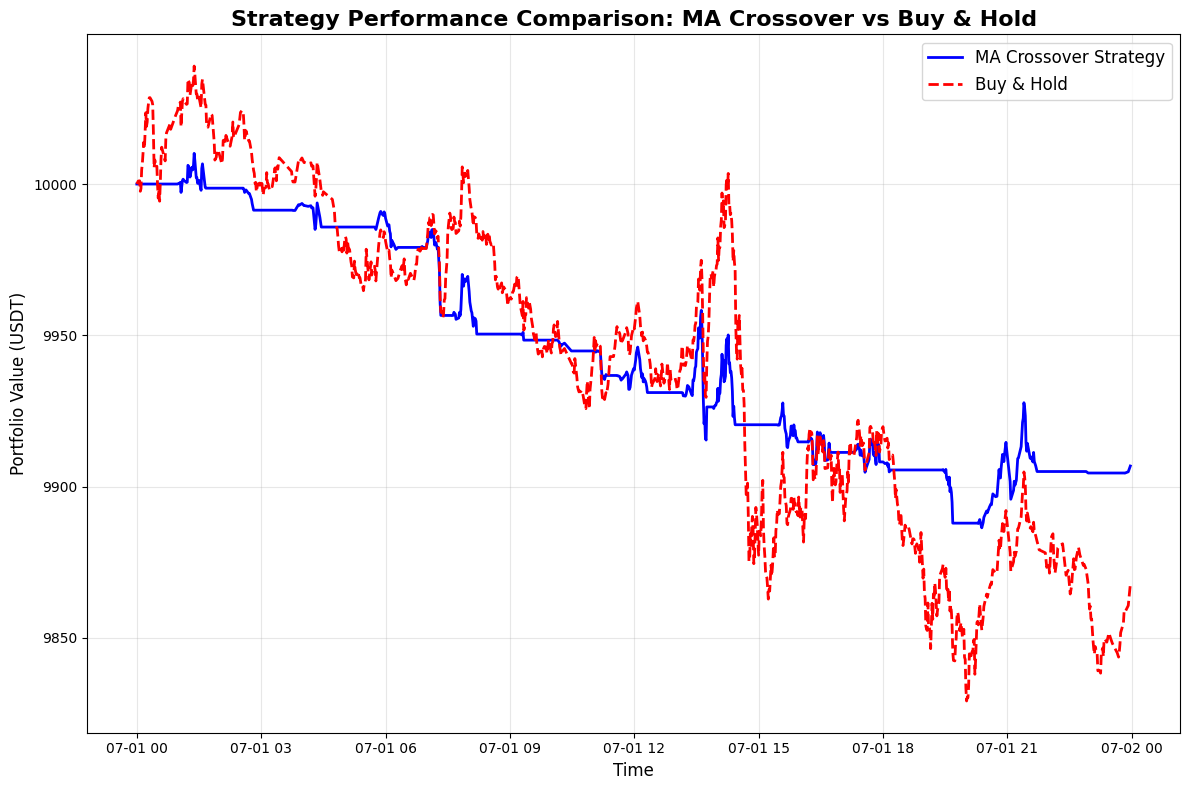

In [ ]:
# Strategy Comparison: MA Crossover vs Buy & Hold
print("🔄 Comparing strategy performance...")

# Calculate buy & hold performance
initial_price = strategy_data['price'].iloc[0]
final_price = strategy_data['price'].iloc[-1]
buy_hold_return = (final_price / initial_price) - 1

# Our strategy return
strategy_return = (backtest_results['portfolio_value'].iloc[-1] / 10000) - 1

# Create comparison DataFrame
comparison_data = pd.DataFrame({
    'Metric': ['Total Return', 'Final Value', 'Performance vs Buy & Hold'],
    'Buy & Hold': [f"{buy_hold_return:.2%}", f"${10000 * (1 + buy_hold_return):.2f}", 'Baseline'],
    'MA Crossover': [f"{strategy_return:.2%}", f"${backtest_results['portfolio_value'].iloc[-1]:.2f}", 
                    f"{((strategy_return - buy_hold_return) / buy_hold_return * 100):.1f}%" if buy_hold_return != 0 else 'N/A']
})

print("Strategy comparison completed!")
print("\nStrategy Performance Comparison:")
print("=" * 60)
print(comparison_data.to_string(index=False))
print("=" * 60)

# Create comparison chart
plt.figure(figsize=(12, 8))

# Portfolio values over time
plt.plot(backtest_results['timestamp'], backtest_results['portfolio_value'], 
         label='MA Crossover Strategy', linewidth=2, color='blue')

# Buy & hold line
buy_hold_values = 10000 * (strategy_data['price'] / initial_price)
plt.plot(strategy_data['timestamp'], buy_hold_values, 
         label='Buy & Hold', linewidth=2, color='red', linestyle='--')

plt.title('Strategy Performance Comparison: MA Crossover vs Buy & Hold', 
          fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Portfolio Value (USDT)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 11. Conclusion and Insights

Summarize the backtesting results and provide actionable insights for strategy improvement.

In [22]:
# Final Insights and Recommendations
print("Analyzing final results and generating insights...")

# Calculate additional insights
total_trades = len(buy_signals) + len(sell_signals)
avg_holding_period = len(strategy_data) / total_trades if total_trades > 0 else 0

print("Analysis complete!")
print("\nKey Insights:")
print("=" * 50)
print(f"Total trades executed: {total_trades}")
print(f"Average holding period: {avg_holding_period:.1f} {performance_metrics.get('Data Frequency', 'time units')}")
print(f"Strategy outperformance: {comparison_data.iloc[2]['MA Crossover']}")
print(f"Sharpe ratio: {performance_metrics['Sharpe Ratio']}")
print(f"Maximum drawdown: {performance_metrics['Max Drawdown']}")
print("=" * 50)

print("\nRecommendations for Strategy Improvement:")
print("1. Optimize MA periods based on market conditions")
print("2. Add stop-loss mechanisms to limit drawdowns")
print("3. Implement position sizing based on volatility")
print("4. Consider adding filters for trend strength")
print("5. Test on different timeframes and assets")

print("\nNext Steps:")
print("• Test with different parameter combinations")
print("• Analyze performance across different market conditions")
print("• Implement risk management features")
print("• Consider machine learning enhancements")

print("\nAdditional Resources:")
print("• CoinAPI Documentation: https://docs.coinapi.io/")
print("• Flat Files API: https://docs.coinapi.io/flat-files-api/")
print("• Trading Strategy Literature")

print("\nTutorial completed successfully!")
print("Happy backtesting!")

Analyzing final results and generating insights...
Analysis complete!

Key Insights:
Total trades executed: 40
Average holding period: 24.9 hour
Strategy outperformance: -29.5%
Sharpe ratio: -4.58
Maximum drawdown: -1.24%

Recommendations for Strategy Improvement:
1. Optimize MA periods based on market conditions
2. Add stop-loss mechanisms to limit drawdowns
3. Implement position sizing based on volatility
4. Consider adding filters for trend strength
5. Test on different timeframes and assets

Next Steps:
• Test with different parameter combinations
• Analyze performance across different market conditions
• Implement risk management features
• Consider machine learning enhancements

Additional Resources:
• CoinAPI Documentation: https://docs.coinapi.io/
• Flat Files API: https://docs.coinapi.io/flat-files-api/
• Trading Strategy Literature

Tutorial completed successfully!
Happy backtesting!
